Let's look at the images that get generated by the tutorial at https://pipelines.lsst.io/getting-started/display.html



In [1]:
# Looks like interactive javascript gets supressed in Jupyter lab, so have to use inline instead
#%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import os

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay

afwDisplay.setDefaultBackend("matplotlib")

In [2]:
# Path to my data
scratch_dir = '/project/shared/data/DATA_ci_hsc/'
full_path = os.path.join(scratch_dir, 'rerun/processCcdOutputs')
# The illustrious Butler
butler = dafPersist.Butler(inputs=full_path)

/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_mosaic/15.0-3-gb1784d1/python/lsst/meas/mosaic/utils.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/traitlets/config/appli

In [3]:
# example of query metadata
butler.queryMetadata('calexp', ['visit', 'ccd'], dataId={'filter': 'HSC-R'})

[(903334, 16),
 (903334, 22),
 (903334, 23),
 (903334, 100),
 (903336, 17),
 (903336, 24),
 (903338, 18),
 (903338, 25),
 (903342, 4),
 (903342, 10),
 (903342, 100),
 (903344, 0),
 (903344, 5),
 (903344, 11),
 (903346, 1),
 (903346, 6),
 (903346, 12)]

In [4]:
# Get a single raw image
raw = butler.get('raw', dataId={'filter': 'HSC-R', 'visit': 903334, 'ccd': 23})

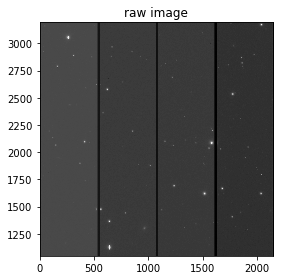

In [5]:
# Useful example notebook for matplotlib display at: 
# https://github.com/lsst/display_matplotlib/blob/master/examples/display_matplotlib.ipynb
disp = afwDisplay.Display(backend="matplotlib")
disp.scale("asinh", "zscale")
title="raw image"
disp.mtv(raw, title=title)
disp.zoom(2)

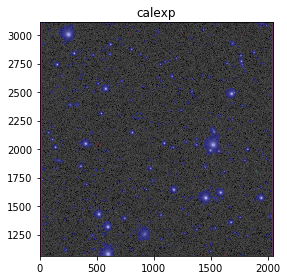

In [6]:

calexp = butler.get('calexp', dataId={'filter': 'HSC-R', 'visit': 903334, 'ccd': 23})
disp2 = afwDisplay.Display(backend="matplotlib")
disp2.scale("asinh", "zscale")
disp2.mtv(calexp, title='calexp')
disp2.zoom(2)

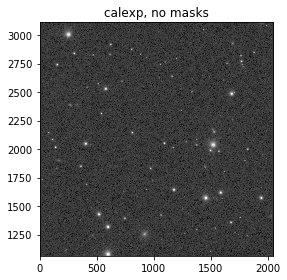

In [7]:

calexp = butler.get('calexp', dataId={'filter': 'HSC-R', 'visit': 903334, 'ccd': 23})
display = afwDisplay.Display(backend="matplotlib")
display.setMaskTransparency(100)  # This needs to be before the mtv call
display.scale("asinh", "zscale")
display.mtv(calexp, title='calexp, no masks')
display.zoom(2)

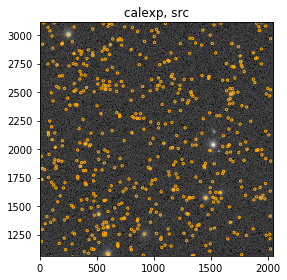

In [8]:
# Use the butler to get the source catalog
src = butler.get('src', dataId={'filter': 'HSC-R', 'visit': 903334, 'ccd': 23})

display = afwDisplay.Display(backend="matplotlib")
display.setMaskTransparency(100)  # This needs to be before the mtv call
display.scale("asinh", "zscale")

display.mtv(calexp, title='calexp, src')

display.zoom(2)
with display.Buffering():
    for s in src:
        display.dot("o", s.getX(), s.getY(), size=10, ctype='orange')

# I'm not sure if these sources are from the reference catalog, or detected, or both?

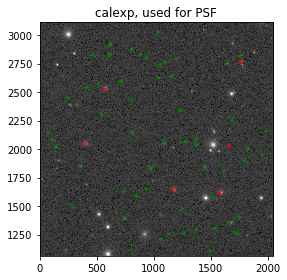

In [9]:
display = afwDisplay.Display(backend="matplotlib")
display.scale("asinh", "zscale")
display.setMaskTransparency(100)
display.mtv(calexp, title='calexp, used for PSF')
display.zoom(2)

# WTF? Why would you use red-x to show things that were used?
# Reversing what the tutorial does

with display.Buffering():
    for s in src[src['calib_psfUsed']]:
        display.dot("+", s.getX(), s.getY(), size=10, ctype='green')

rejectedPsfSources = src[src['calib_psfCandidate'] &
                         (src['calib_psfUsed'] == False)]
with display.Buffering():
    for s in rejectedPsfSources:
        display.dot("x", s.getX(), s.getY(), size=10, ctype='red')

In [10]:
# Can I grab the WCS and get the coordinates of 1000,2000?
wcs = calexp.getWcs()
spot_of_interest = wcs.pixelToSky(1000, 2000)

In [11]:
# Pretty sure this is supposed to work
butler.getKeys()

AttributeError: 'NoneType' object has no attribute 'find'

In [12]:
butler.getKeys('deepCoadd')

{'filter': str, 'tract': int, 'patch': str}

In [13]:
# So, it knows deepCoadds are things, but not where they are. 
coadd = butler.get('deepCoadd', dataId={'patch': '0,1', 'tract': 0, 'filter': 'HSC-R'})

NoResults: No locations for get: datasetType:deepCoadd dataId:DataId(initialdata={'patch': '0,1', 'tract': 0, 'filter': 'HSC-R'}, tag=set())

In [15]:
# Do I need to setup a new butler?
full_path = os.path.join(scratch_dir, 'rerun/coadd')
butler = dafPersist.Butler(inputs=full_path)


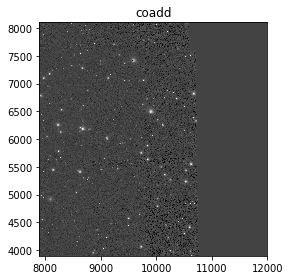

In [16]:
coadd = butler.get('deepCoadd', dataId={'patch': '2,1', 'tract': 0, 'filter': 'HSC-R'})
display = afwDisplay.Display(backend="matplotlib")
display.setMaskTransparency(100)  # This needs to be before the mtv call
display.scale("asinh", "zscale")
display.mtv(coadd, title='coadd')
#display.zoom(4)

In [17]:
# Need to figure out what the coordinates of my spot are.
wcs = coadd.getWcs()
wcs.skyToPixel(spot_of_interest)
# Hmm, looks like all the WCS are the same on the patches. Nifty. 

Point2D(8644.028386, 6685.557776)

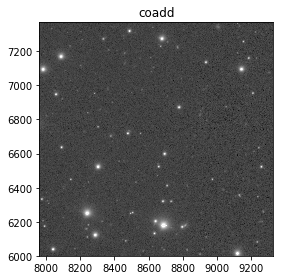

In [18]:
display = afwDisplay.Display(backend="matplotlib")
display.setMaskTransparency(100)  
display.scale("asinh", "zscale")
display.mtv(coadd, title='coadd')
display.zoom(6, 8644, 6685)

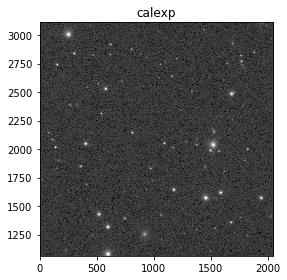

In [21]:
# Here's a single exposure again for comparison. Note image above is rotated.
display = afwDisplay.Display(backend="matplotlib")
display.setMaskTransparency(100)  
display.scale("asinh", "zscale")
display.setMaskTransparency(100) 
display.mtv(calexp, title='calexp')
display.zoom(2)